In [118]:
from textblob import TextBlob as tb
import math

import pandas as pd
import numpy as np
import string
import re
import nltk
nltk.download('punkt')
# nltk.download()

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.naive_bayes import GaussianNB

[nltk_data] Downloading package punkt to /Users/juanolmos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [119]:
df = pd.read_csv("../data/svm_tweets/twitter_training.csv", header = None)
df = df[df[1] == "Amazon"]
df.columns = ["c0","c1","class","text"] 
# df = df.drop_duplicates(inplace = True)
n_positives = np.sum(df["class"] == "Positive")
n_negatives = np.sum(df["class"] == "Negative")
print(f"There is {n_positives} Positives AND {n_negatives} Negatives")
df = df[(df["class"] == "Positive") | (df["class"] == "Negative")]
size = 300        # sample size
replace = True  # with replacement
fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]
df = df.groupby('class', as_index=False).apply(fn).reset_index()
df = df[["text","class"]]
df["text"] = df["text"].astype("str")
df["class"] = df["class"].replace(["Negative","Positive"],[0,1])
df

There is 312 Positives AND 576 Negatives


,text,class
0,Researchers disclosed flaws in Amazon Alexa pr...,0
1,@amazon @AmazonHelp still my b a t not recieve...,0
2,"Amazon is holding over 4.2M dollars, suffocati...",0
3,felt fucked <unk>,0
4,remembered im calling amazon friend to f see w...,0
...,...,...
595,People are so incredibly wicked sometimes in t...,1
596,All this digital price tag data gon be amazing...,1
597,For those two of you you all that would love t...,1
598,Congratulations on our newest Amazon gift card...,1


In [120]:
def clean_text(text):
    ps = nltk.PorterStemmer()
    stopword = nltk.corpus.stopwords.words('english')
    text_lc = "".join([word.lower() for word in text if word not in string.punctuation]) # remove puntuation
    text_rc = re.sub('[0-9]+', '', text_lc)
    tokens = re.split('\W+', text_rc)    # tokenization
    text = [ps.stem(word) for word in tokens if word not in stopword]  # remove stopwords and stemming
    return " ".join(text)

df["new_text"] = df["text"].apply(lambda x: clean_text(x))
df    

,text,class,new_text
0,Researchers disclosed flaws in Amazon Alexa pr...,0,research disclos flaw amazon alexa product cou...
1,@amazon @AmazonHelp still my b a t not recieve...,0,amazon amazonhelp still b reciev month
2,"Amazon is holding over 4.2M dollars, suffocati...",0,amazon hold dollar suffoc busi sellercentralam...
3,felt fucked <unk>,0,felt fuck unk
4,remembered im calling amazon friend to f see w...,0,rememb im call amazon friend f see got charg b...
...,...,...,...
595,People are so incredibly wicked sometimes in t...,1,peopl incred wick sometim life know name covid...
596,All this digital price tag data gon be amazing...,1,digit price tag data gon amaz amazon inevit split
597,For those two of you you all that would love t...,1,two would love use amazon potenti even get fav...
598,Congratulations on our newest Amazon gift card...,1,congratul newest amazon gift card winner annni...



$tf = \frac{fr_{td}}{length_d}$

$idf = log(\frac{N}{n_j})$

In [121]:
def tf(word, blob): #frecuencia de palabra en documento
    return blob.words.count(word) / len(blob.words)

def n_containing(word, bloblist): #en cuantos documentos aparece
    return sum(1 for blob in bloblist if word in blob.words)

def idf(word, bloblist): #idf
    return math.log(len(bloblist) / (1 + n_containing(word, bloblist)))

def tfidf(word, blob, bloblist): #tf-idf
    return tf(word, blob) * idf(word, bloblist)

def glasgow(word, blob, bloblist):
    term1 = math.log( 1 + blob.words.count(word)) / math.log(len(blob.words) + 1e-3)
    term2 = math.log(1 + (len(bloblist) / n_containing(word, bloblist)))
    return term1 * term2

In [122]:
def generate_words_matrix(bloblist):
    words_matrix = []
    for blob in bloblist:
        for word in blob.words:
            words_matrix.append(word)
    words_matrix = set(words_matrix)        
    print(f"Number of words {len(words_matrix)}")
    return words_matrix

def twm_matrix(words_matrix,bloblist, metric):
    twm = {}
    for w in words_matrix:
        twm[w] = []
    
    for blob in bloblist:
        # print(blob)
        for word in words_matrix:
            if word in blob.words:
                if metric=="tf-idf":
                    score = tfidf(word, blob, bloblist)
                    twm[word].append(score)
                elif metric=="glasgow":
                    score = glasgow(word, blob, bloblist)
                    twm[word].append(score)
            else:
                twm[word].append(0)
                # print(w)
    return pd.DataFrame(twm)

def get_crf(twm):
    X = twm.values[:,:]
    # print(f'X shape: {X.shape}')
    probs = np.mean(X, axis = 0) 
    probs = pd.DataFrame({"Probs":probs})
    probs = probs.sort_values(by = "Probs", ascending=False)
    probs["probs2"] = probs["Probs"] / probs["Probs"].sum()
    probs["crf"] = probs["probs2"].cumsum()
    return probs.crf
                        

In [123]:
bloblist = [tb(text) for text in df["new_text"].values]
words_matrix = generate_words_matrix(bloblist)

twm_tfidf = twm_matrix(words_matrix,bloblist, metric = "tf-idf")
twm_glasgow = twm_matrix(words_matrix,bloblist, metric = "glasgow")

crf_tfidf = get_crf(twm_tfidf)
crf_glasgow = get_crf(twm_glasgow)

Number of words 1268


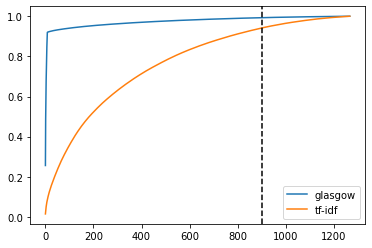

In [125]:
xx = np.arange(len(crf_tfidf))

fig, ax = plt.subplots()
plt.plot(xx,crf_glasgow, label = "glasgow")
plt.plot(xx,crf_tfidf, label = "tf-idf")
# plt.xscale("log")
plt.axvline(900, c="k", linestyle = "--")
plt.legend()

In [132]:
def get_firsts(twm, n_top):
    X = twm.values[:,:]
    # print(f'X shape: {X.shape}')
    probs = np.mean(X, axis = 0) 
    probs = pd.DataFrame({"Probs":probs})
    probs = probs.sort_values(by = "Probs", ascending=False)
    # display(probs)

    top_words = probs.index[:n_top]
    # print(top_words)
    # display(twm)
    return twm[twm.columns[top_words]]

def get_name_firsts(twm, n_top):
    X = twm.values[:,:]
    # print(f'X shape: {X.shape}')
    probs = np.mean(X, axis = 0) 
    probs = pd.DataFrame({"Probs":probs})
    probs = probs.sort_values(by = "Probs", ascending=False)
    # display(probs)

    top_words = probs.index[:n_top]
    twm = twm[twm.columns[top_words]]
    # print(top_words)
    # display(twm)
    
    return twm.mask(twm > 0,1)
 

In [133]:
get_name_firsts(twm_tfidf, n_top = 900)

,nan,woah,fuck,intrigu,thank,recommend,amazon,one,order,prime,...,brought,emi,convers,heck,fever,plu,sport,collect,oss,where
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
596,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
597,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
598,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [137]:
twm_tfidf_top = get_name_firsts(twm_tfidf, n_top = 100)
twm_glasgow_top = get_name_firsts(twm_glasgow, n_top = 100)

In [138]:
def calculate_metrics(df,mop):    
    print(mop.shape)
    X, y = mop.values, df["class"].values    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    for name_clf, clf in zip(["NAIVE BAYES","SVM"],[GaussianNB(),SVC()]):        
        clf.fit(X, y)
        y_pred = clf.predict(X_test)
        """ 
        -----   Metrics  -----
        """   
        acc = accuracy_score(y_test, y_pred)
        prf = precision_recall_fscore_support(y_test, y_pred,zero_division=0.0)
        pre, spe, sen, f1s = prf[0][1], prf[1][0], prf[1][1], prf[2][1]

        metrics_df = pd.DataFrame({'Recall': [sen],                    
                            'Precision': [pre],
                            'Accuracy': [acc],
                            'F1-Score': [f1s]})
        print(f"Results using: {name_clf}'")            
        display(metrics_df)

In [139]:
calculate_metrics(df,twm_tfidf_top)

calculate_metrics(df,twm_glasgow_top)

(600, 100)
Results using: NAIVE BAYES'


,Recall,Precision,Accuracy,F1-Score
0,0.551724,0.941176,0.766667,0.695652


Results using: SVM'


,Recall,Precision,Accuracy,F1-Score
0,0.931034,1.0,0.966667,0.964286


(600, 100)
Results using: NAIVE BAYES'


,Recall,Precision,Accuracy,F1-Score
0,0.844828,0.890909,0.875,0.867257


Results using: SVM'


,Recall,Precision,Accuracy,F1-Score
0,0.965517,1.0,0.983333,0.982456
